# Problem 1 - Yield curve

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import fixed_income_derivatives_E2025 as fid
import matplotlib.pyplot as plt

In [2]:
alpha_caplet = 0.5
N_caplet = 21
T_caplet = np.array([i*alpha_caplet for i in range(0,N_caplet)])
strike_caplet_market = 0.055
price_caplet_market = np.array([0, 0, 3.592, 19.2679, 32.1887, 37.2136, 36.475, 32.2678, 26.9031, 21.2176, 16.2022, 12.0628,
8.8952, 6.5191, 4.8435, 3.6485, 2.8098, 2.2067, 1.7814, 1.4707, 1.2443])
price_caplet_market = price_caplet_market/10000

K_swaption_offset = np.array([-300,-250,-200,-150,-100,-50,0,50,100,150,200,250,300])
iv_swaption_market = np.array([0.220675, 0.18331, 0.155103, 0.129001, 0.10812, 0.084411, 0.071866, 0.066535, 0.073942, 0.082751, 0.093605, 0.098971, 0.108909])

EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.03772}]
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate": 0.04026},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.04261},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.04477},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.04677},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.0486},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.05029},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.05183},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.05324},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.05452}]
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.05228, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.05602, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.05755, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.05791, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.05718, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.05539, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.05324, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.05205, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.05087, "float_freq": "semiannual", "fixed_freq": "annual","indices": []}]
data_zcb = EURIBOR_fixing + fra_market + swap_market

# Problem 1 - Computing the 10Y swap par swap rate
# 1a) Fitting the yield curve
mesh = 1/12
M = 360
interpolation_options = {"method":"hermite","degree":3,"transition": "smooth"}
T_fit, R_fit = fid.zcb_curve_fit(data_zcb,interpolation_options = interpolation_options)
T_inter = np.array([i*mesh for i in range(0,M+1)])
p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_inter,T_fit,R_fit,interpolation_options = interpolation_options)
R_output = fid.for_values_in_list_find_value_return_value([0.5,1,2,5,10,15,20,30],T_inter,R_inter)
r0 = R_inter[0]
print(f"Problem 1a - 6M,1Y,2Y,5Y,10Y,15Y,20Y,30Y spot rates from the fit: {np.round(R_output,5)}")
# 1c) Computing the 10Y par swap rate
alpha_floating_leg = 0.5
T_10Y_swap = np.array([i*alpha_floating_leg for i in range(0,21)])
p_10Y_swap = fid.for_values_in_list_find_value_return_value(T_10Y_swap,T_inter,p_inter)
L_6M = fid.forward_rates_from_zcb_prices(T_10Y_swap,p_10Y_swap,horizon = 1)
R_10Y_swap, S_10Y_swap = fid.swap_rate_from_zcb_prices(0,0,10,"annual",T_10Y_swap,p_10Y_swap)
print(f"Problem 1c - 10Y par swap rate: {R_10Y_swap}")


Problem 1a - 6M,1Y,2Y,5Y,10Y,15Y,20Y,30Y spot rates from the fit: [0.03737 0.04352 0.05115 0.05666 0.05361 0.05102 0.04955 0.04804]
Problem 1c - 10Y par swap rate: 0.05538999999980689


#### 1.a PLOT

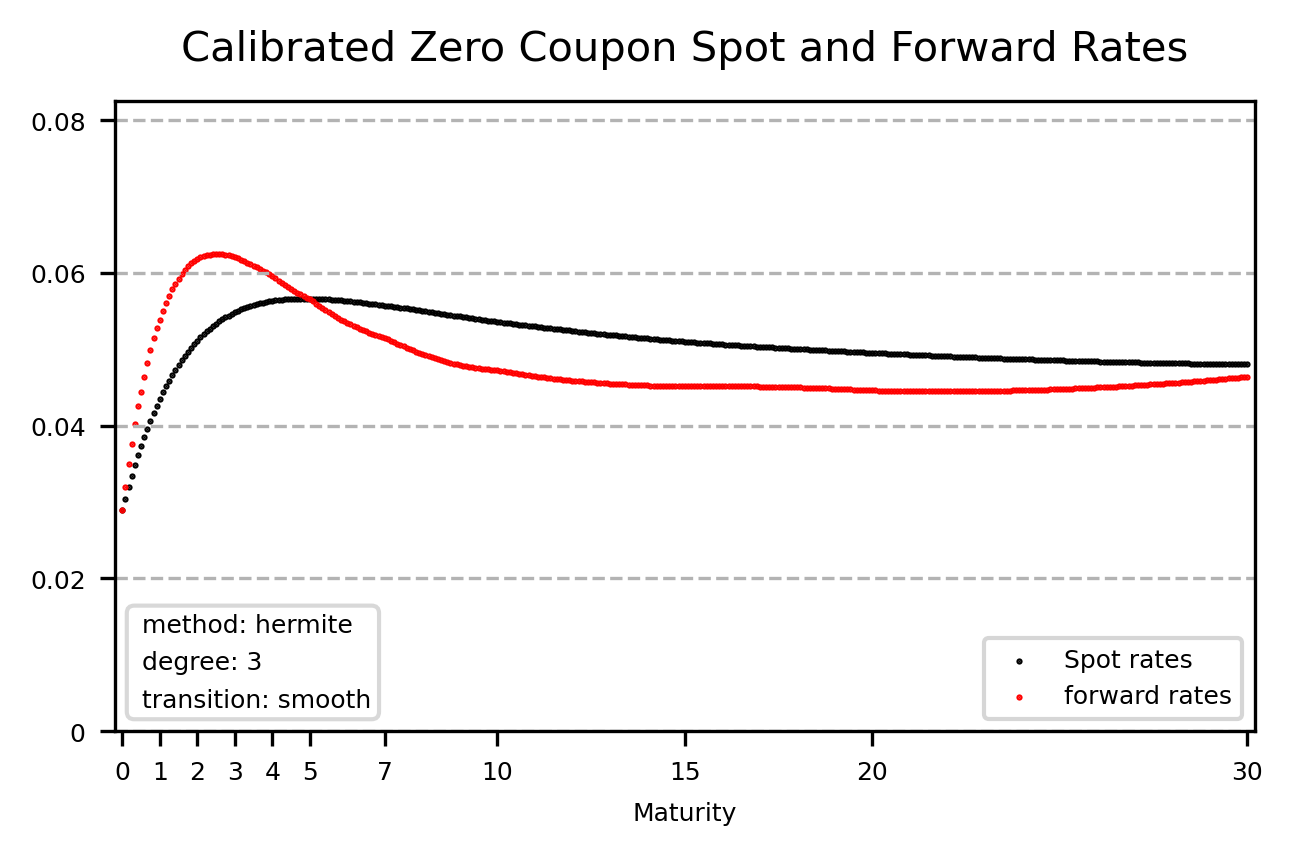

In [3]:

# 1.a: PLot of the fitted ZCB term structures of spot and forward rates
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated Zero Coupon Spot and Forward Rates", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([0,0.0825])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter[0:], R_inter[0:], s = 1, color = 'black', marker = ".",label="Spot rates")
p2 = ax.scatter(T_inter[0:], f_inter[0:], s = 1, color = 'red', marker = ".",label="forward rates")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
bbox = {"facecolor": (1,1,1,0.8),"edgecolor": (0.7,0.7,0.7,0.5),"boxstyle": "Round"}
if interpolation_options["method"] == "hermite":
    ax.text(0.32,0.0032,f" method: {interpolation_options['method']} \n degree: {interpolation_options['degree']} \n transition: {interpolation_options['transition']}", fontsize = 6,linespacing = 1.7, bbox = bbox)
else:
    ax.text(0.32,0.0032,f" method: {interpolation_options['method']} \n transition: {interpolation_options['transition']}", fontsize = 6,linespacing = 1.7, bbox = bbox)
fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/1a_zcb_term_structure.pdf")
# plt.show()

# Problem 2 - Pricing the interest rate cap

In [4]:
# Problem 2 - Pricing the interest rate cap
def fit_hwev_caplet_prices(param,price,strike_observed,T,p,scaling = 1):
    a, sigma = param
    caplet_price_fit = fid.caplet_prices_hwev(strike_observed,a,sigma,T,p)
    M = len(price)
    sse = 0
    for m in range(0,M):
        sse += scaling*(price[m] - caplet_price_fit[m])**2
    return sse

In [5]:

# 2a) Fitting a Vasicek model to the yield curve
sigma_vasicek = 0.02
param_0 = 0.035, 6, 0.25
result = minimize(fid.fit_vasicek_sigma_fixed_obj,param_0,method = 'nelder-mead',args = (sigma_vasicek,R_inter,T_inter),options={'xatol': 1e-20,'disp': False})
r0_vasicek, a_vasicek, b_vasicek = result.x
print(f"Problem 2a - Vaseicek parameters: r0: {r0_vasicek}, a: {a_vasicek}, b: {b_vasicek}, sigma: {sigma_vasicek}, SSE: {result.fun}")
p_vasicek = fid.zcb_price_vasicek(r0_vasicek,a_vasicek,b_vasicek,sigma_vasicek,T_inter)
f_vasicek = fid.forward_rate_vasicek(r0_vasicek,a_vasicek,b_vasicek,sigma_vasicek,T_inter)
R_vasicek = fid.spot_rate_vasicek(r0_vasicek,a_vasicek,b_vasicek,sigma_vasicek,T_inter)


Problem 2a - Vaseicek parameters: r0: 0.02498727211908541, a: 5.575090910438922, b: 0.28860088559605496, sigma: 0.02, SSE: 0.003570509776348457


In [6]:
# 2b) Fitting the HWEV model to caplet prices
param_0 = 2.5, 0.018
result = minimize(fit_hwev_caplet_prices,param_0,method = 'nelder-mead',args = (price_caplet_market,strike_caplet_market,T_10Y_swap,p_10Y_swap),options={'xatol': 1e-20,'disp': False})
a_hwev, sigma_hwev = result.x
print(f"Problem 2b - HWEV parameters: a: {a_hwev}, sigma: {sigma_hwev}, SSE: {result.fun}")
caplet_price_fit = fid.caplet_prices_hwev(strike_caplet_market,a_hwev,sigma_hwev,T_10Y_swap,p_10Y_swap)
sigma_market, sigma_fit = np.nan*np.ones(N_caplet), np.nan*np.ones(N_caplet)
for i in range(2,N_caplet):
    sigma_market[i] = fid.black_caplet_iv(price_caplet_market[i],T_10Y_swap[i],strike_caplet_market,0.5,p_10Y_swap[i],L_6M[i],type_option = "call",prec = 1e-10)
    sigma_fit[i] = fid.black_caplet_iv(caplet_price_fit[i],T_10Y_swap[i],strike_caplet_market,0.5,p_10Y_swap[i],L_6M[i],type_option = "call",prec = 1e-10)


Problem 2b - HWEV parameters: a: 2.032982168566001, sigma: 0.020307157978552468, SSE: 5.033837247986103e-09


In [7]:

# 2c) - Simulated trajectories of the Vasick and HWEV models
size_ci = 0.95
M_simul, T_simul = 500, 10
mesh_simul = T_simul/M_simul
t_simul = np.array([i*mesh_simul for i in range(0,M_simul+1)])
r_simul_vasicek = fid.simul_vasicek(r0_vasicek,a_vasicek,b_vasicek,sigma_vasicek,M_simul,T_simul,method = "euler")
mean_vasicek = fid.mean_vasicek(r0_vasicek, a_vasicek, b_vasicek, sigma_vasicek,t_simul)
lb_vasicek, ub_vasicek = fid.ci_vasicek(r0_vasicek, a_vasicek, b_vasicek, sigma_vasicek,t_simul,size_ci,type_ci = "two_sided")
lb_sd_vasicek, ub_sd_vasicek = fid.ci_vasicek(r0_vasicek, a_vasicek, b_vasicek, sigma_vasicek,np.inf,size_ci,type_ci = "two_sided")
print(f"Problem 2c - Vasicek model 2-sided CI under the stationary distribution: {lb_sd_vasicek}, {ub_sd_vasicek}")
f_simul, f_T_simul = fid.interpolate(t_simul,T_inter,f_inter,interpolation_options)
theta_hwev = fid.theta_hwev(t_simul,f_simul,f_T_simul,a_hwev,sigma_hwev)
r_simul_hwev = fid.simul_hwev(r0,t_simul,theta_hwev,a_hwev,sigma_hwev,method = "euler")
mean_hwev, var_hwev = fid.mean_var_hwev(a_hwev,sigma_hwev,t_simul,f_simul,f_T_simul)
lb_hwev, ub_hwev = fid.ci_hwev(a_hwev,sigma_hwev,t_simul,f_simul,f_T_simul,size_ci,type_ci = "two_sided")
print(f"HWEV model 2-sided CI under the stationary distribution: {lb_hwev[-1]}, {ub_hwev[-1]}")

Problem 2c - Vasicek model 2-sided CI under the stationary distribution: 0.04002696841849589, 0.0635052932906979
HWEV model 2-sided CI under the stationary distribution: 0.027563383164067812, 0.06704050223292485


In [8]:

# 2d) - Price of the interest cap
strike_cap = 0.06
caplet_price_cap = fid.caplet_prices_hwev(strike_cap,a_hwev,sigma_hwev,T_10Y_swap,p_10Y_swap)
caplet_price_report = []
for i in [2,4,8,12,16,20]:
    caplet_price_report.append(np.round(10000*caplet_price_cap[i],4))
price_cap = sum(caplet_price_cap[2:])
premium_cap = alpha_floating_leg*price_cap/S_10Y_swap
print(f"Problem 2d - Caplet prices for T=1,2,4,6,8,10: {caplet_price_report}")
print(f"Problem 2d - price_cap: {10000*price_cap}, premium_cap: {10000*premium_cap}")


Problem 2d - Caplet prices for T=1,2,4,6,8,10: [np.float64(0.6687), np.float64(15.8546), np.float64(12.8065), np.float64(2.6277), np.float64(0.6122), np.float64(0.2263)]
Problem 2d - price_cap: 120.3749661196188, premium_cap: 8.033312945497595


# Problem 3 - Computing the price of the 3Y7Y payer swaption

In [9]:
# 3a) 3Y7Y swaption price
T_n, T_N = 3, 10
beta = 0.55
R_swaption, S_swaption = fid.swap_rate_from_zcb_prices(0,T_n,T_N,"annual",T_10Y_swap,p_10Y_swap)
print(f"ATMF 3Y7Y par swap rate: {R_swaption}")
N_swaption = len(K_swaption_offset)
K_swaption = K_swaption_offset/10000 + R_swaption*np.ones(N_swaption)
price_swaption_market = np.zeros([N_swaption])
for i in range(0,N_swaption):
    price_swaption_market[i] = fid.black_swaption_price(iv_swaption_market[i],T_n,K_swaption[i],S_swaption,R_swaption)
print(f"Payer swaption with strike closest to K=0.06. strike: {K_swaption[7]}, price: {price_swaption_market[7]*10000} bps")


ATMF 3Y7Y par swap rate: 0.05503331345783611
Payer swaption with strike closest to K=0.06. strike: 0.06003331345783611, price: 41.195444387893204 bps


In [10]:
# 3b) Fitting the SABR model
param_0 = 0.025, 0.48,-0.25
result = minimize(fid.fit_sabr_no_beta_obj,param_0,method = 'nelder-mead',args = (beta,iv_swaption_market,K_swaption,T_n,R_swaption),options={'xatol': 1e-8,'disp': False})
sigma_0, upsilon, rho = result.x
print(f"Parameters from the SABR fit where beta: {beta} are: sigma_0: {sigma_0}, upsilon: {upsilon}, rho: {rho}, SSE: {result.fun}")
iv_fit, price_fit = np.zeros([N_swaption]), np.zeros([N_swaption])
for i in range(0,N_swaption):
    iv_fit[i] = fid.sigma_sabr(K_swaption[i],T_n,R_swaption,sigma_0,beta,upsilon,rho)
    price_fit[i] = fid.black_swaption_price(iv_fit[i],T_n,K_swaption[i],S_swaption,R_swaption,type_option = "call")


Parameters from the SABR fit where beta: 0.55 are: sigma_0: 0.017875223851695068, upsilon: 0.5840153631324319, rho: -0.3439552092629677, SSE: 2.798846154816731e-05


In [11]:
# 3c) Price and risk management of a strangle
iv_payer_swaption = fid.sigma_sabr(K_swaption[8],T_n,R_swaption,sigma_0,beta,upsilon,rho)
price_payer_swaption_init = fid.black_swaption_price(iv_payer_swaption,T_n,K_swaption[8],S_swaption,R_swaption,type_option = "call")
iv_receiver_swaption = fid.sigma_sabr(K_swaption[4],T_n,R_swaption,sigma_0,beta,upsilon,rho)
price_receiver_swaption_init = fid.black_swaption_price(iv_receiver_swaption,T_n,K_swaption[4],S_swaption,R_swaption,type_option = "put")
print(f"Initially. Payer swaption: {price_payer_swaption_init*10000}, Receiver swaption: {price_receiver_swaption_init*10000}, Strangle: {price_payer_swaption_init*10000+price_receiver_swaption_init*10000}")
bps = 0.0001
iv_payer_swaption = fid.sigma_sabr(K_swaption[8],T_n,R_swaption + bps,sigma_0,beta,upsilon,rho)
price_payer_swaption = fid.black_swaption_price(iv_payer_swaption,T_n,K_swaption[8],S_swaption,R_swaption + bps,type_option = "call")
iv_receiver_swaption = fid.sigma_sabr(K_swaption[4],T_n,R_swaption + bps,sigma_0,beta,upsilon,rho)
price_receiver_swaption = fid.black_swaption_price(iv_receiver_swaption,T_n,K_swaption[4],S_swaption,R_swaption + bps,type_option = "put")
print(f"Par swap rate UP 1 bps. Payer swaption: {price_payer_swaption*10000}, Receiver swaption: {price_receiver_swaption*10000}, Strangle: {price_payer_swaption*10000+price_receiver_swaption*10000}, Difference: {10000*(price_payer_swaption+price_receiver_swaption-price_payer_swaption_init-price_receiver_swaption_init)}")
iv_payer_swaption = fid.sigma_sabr(K_swaption[8],T_n,R_swaption - bps,sigma_0,beta,upsilon,rho)
price_payer_swaption = fid.black_swaption_price(iv_payer_swaption,T_n,K_swaption[8],S_swaption,R_swaption - bps,type_option = "call")
iv_receiver_swaption = fid.sigma_sabr(K_swaption[4],T_n,R_swaption - bps,sigma_0,beta,upsilon,rho)
price_receiver_swaption = fid.black_swaption_price(iv_receiver_swaption,T_n,K_swaption[4],S_swaption,R_swaption - bps,type_option = "put")
print(f"Par swap rate DOWN 1 bps. Payer swaption: {price_payer_swaption*10000}, Receiver swaption: {price_receiver_swaption*10000}, Strangle: {price_payer_swaption*10000+price_receiver_swaption*10000}, Difference: {10000*(price_payer_swaption+price_receiver_swaption-price_payer_swaption_init-price_receiver_swaption_init)}")
iv_payer_swaption = fid.sigma_sabr(K_swaption[8],T_n,R_swaption,sigma_0 + 0.001,beta,upsilon,rho)
price_payer_swaption = fid.black_swaption_price(iv_payer_swaption,T_n,K_swaption[8],S_swaption,R_swaption,type_option = "call")
iv_receiver_swaption = fid.sigma_sabr(K_swaption[4],T_n,R_swaption,sigma_0 + 0.001,beta,upsilon,rho)
price_receiver_swaption = fid.black_swaption_price(iv_receiver_swaption,T_n,K_swaption[4],S_swaption,R_swaption,type_option = "put")
print(f"Volatility 0.001 UP. Payer swaption: {price_payer_swaption*10000}, Receiver swaption: {price_receiver_swaption*10000}, Strangle: {price_payer_swaption*10000+price_receiver_swaption*10000}, Difference: {10000*(price_payer_swaption+price_receiver_swaption-price_payer_swaption_init-price_receiver_swaption_init)}")
iv_payer_swaption = fid.sigma_sabr(K_swaption[8],T_n,R_swaption,sigma_0 - 0.001,beta,upsilon,rho)
price_payer_swaption = fid.black_swaption_price(iv_payer_swaption,T_n,K_swaption[8],S_swaption,R_swaption,type_option = "call")
iv_receiver_swaption = fid.sigma_sabr(K_swaption[4],T_n,R_swaption,sigma_0 - 0.001,beta,upsilon,rho)
price_receiver_swaption = fid.black_swaption_price(iv_receiver_swaption,T_n,K_swaption[4],S_swaption,R_swaption,type_option = "put")
print(f"Volatility 0.001 DOWN. Payer swaption: {price_payer_swaption*10000}, Receiver swaption: {price_receiver_swaption*10000}, Strangle: {price_payer_swaption*10000+price_receiver_swaption*10000}, Difference: {10000*(price_payer_swaption+price_receiver_swaption-price_payer_swaption_init-price_receiver_swaption_init)}")


Initially. Payer swaption: 16.053096667407942, Receiver swaption: 31.424116085775022, Strangle: 47.47721275318297
Par swap rate UP 1 bps. Payer swaption: 16.35234104159374, Receiver swaption: 31.13234003219374, Strangle: 47.48468107378748, Difference: 0.007468320604511747
Par swap rate DOWN 1 bps. Payer swaption: 15.76079054120206, Receiver swaption: 31.72019106310972, Strangle: 47.48098160431178, Difference: 0.003768851128812742
Volatility 0.001 UP. Payer swaption: 18.57246035677486, Receiver swaption: 35.03239454085507, Strangle: 53.604854897629934, Difference: 6.127642144446972
Volatility 0.001 DOWN. Payer swaption: 13.72821984857286, Receiver swaption: 27.959714097606827, Strangle: 41.68793394617968, Difference: -5.789278807003277


# Problem 5 - Short rate dynamics

In [12]:
# problem 5
def mean_var(x0,a,b,sigma,y0,gamma,phi,T):
    N = len(T)
    mean = np.zeros(N)
    var = np.zeros(N)
    for n, t in enumerate(T):
        mean[n] = x0*np.exp(-gamma*T[n]) + y0*np.exp(-a*T[n]) + b/a*(1-np.exp(-a*T[n]))
        var[n] = phi**2/(2*gamma)*(1-np.exp(-2*gamma*T[n])) + sigma**2/(2*a)*(1-np.exp(-2*a*T[n]))
    return mean, var

# 5c) Simulating the factors driving the short rate and the short rate itself
x0, gamma, phi = 0, 32, 0.03
y0, a, b, sigma = 0.03, 0.5, 0.025, 0.015
M = 1000
T_st = 1
T_lt = 10
size_ci = 0.95
z = norm.ppf(size_ci + 0.5*(1-size_ci),0,1)
delta_st = T_st/M
t_simul_st = np.array([i*delta_st for i in range(0,M+1)])
X_st = fid.simul_vasicek(x0,gamma,0,phi,M,T_st)
Y_st = fid.simul_vasicek(y0,a,b,sigma,M,T_st)
r_st = X_st + Y_st
mean_st, var_st = mean_var(x0,a,b,sigma,y0,gamma,phi,t_simul_st)
lb_st, ub_st = mean_st - z*np.sqrt(var_st), mean_st + z*np.sqrt(var_st)
delta_lt = T_lt/M
t_simul_lt = np.array([i*delta_lt for i in range(0,M+1)])
X_lt = fid.simul_vasicek(x0,gamma,0,phi,M,T_lt)
Y_lt = fid.simul_vasicek(y0,a,b,sigma,M,T_lt)
r_lt = X_lt + Y_lt
mean_lt, var_lt = mean_var(x0,a,b,sigma,y0,gamma,phi,t_simul_lt)
lb_lt, ub_lt = mean_lt - z*np.sqrt(var_lt), mean_lt + z*np.sqrt(var_lt)


# PLOTS

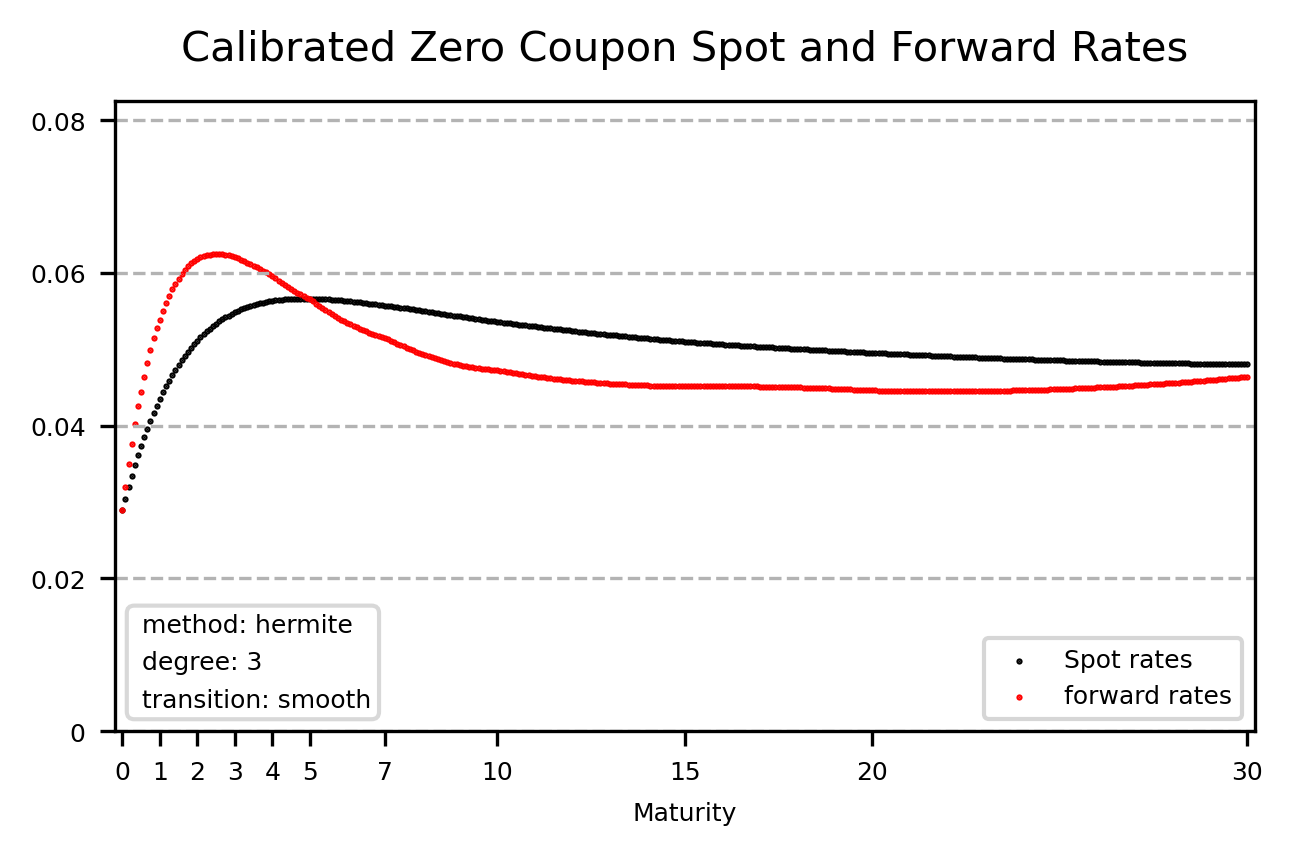

In [13]:

# 1.a: PLot of the fitted ZCB term structures of spot and forward rates
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated Zero Coupon Spot and Forward Rates", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([0,0.0825])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter[0:], R_inter[0:], s = 1, color = 'black', marker = ".",label="Spot rates")
p2 = ax.scatter(T_inter[0:], f_inter[0:], s = 1, color = 'red', marker = ".",label="forward rates")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
bbox = {"facecolor": (1,1,1,0.8),"edgecolor": (0.7,0.7,0.7,0.5),"boxstyle": "Round"}
if interpolation_options["method"] == "hermite":
    ax.text(0.32,0.0032,f" method: {interpolation_options['method']} \n degree: {interpolation_options['degree']} \n transition: {interpolation_options['transition']}", fontsize = 6,linespacing = 1.7, bbox = bbox)
else:
    ax.text(0.32,0.0032,f" method: {interpolation_options['method']} \n transition: {interpolation_options['transition']}", fontsize = 6,linespacing = 1.7, bbox = bbox)
fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/1a_zcb_term_structure.pdf")
# plt.show()


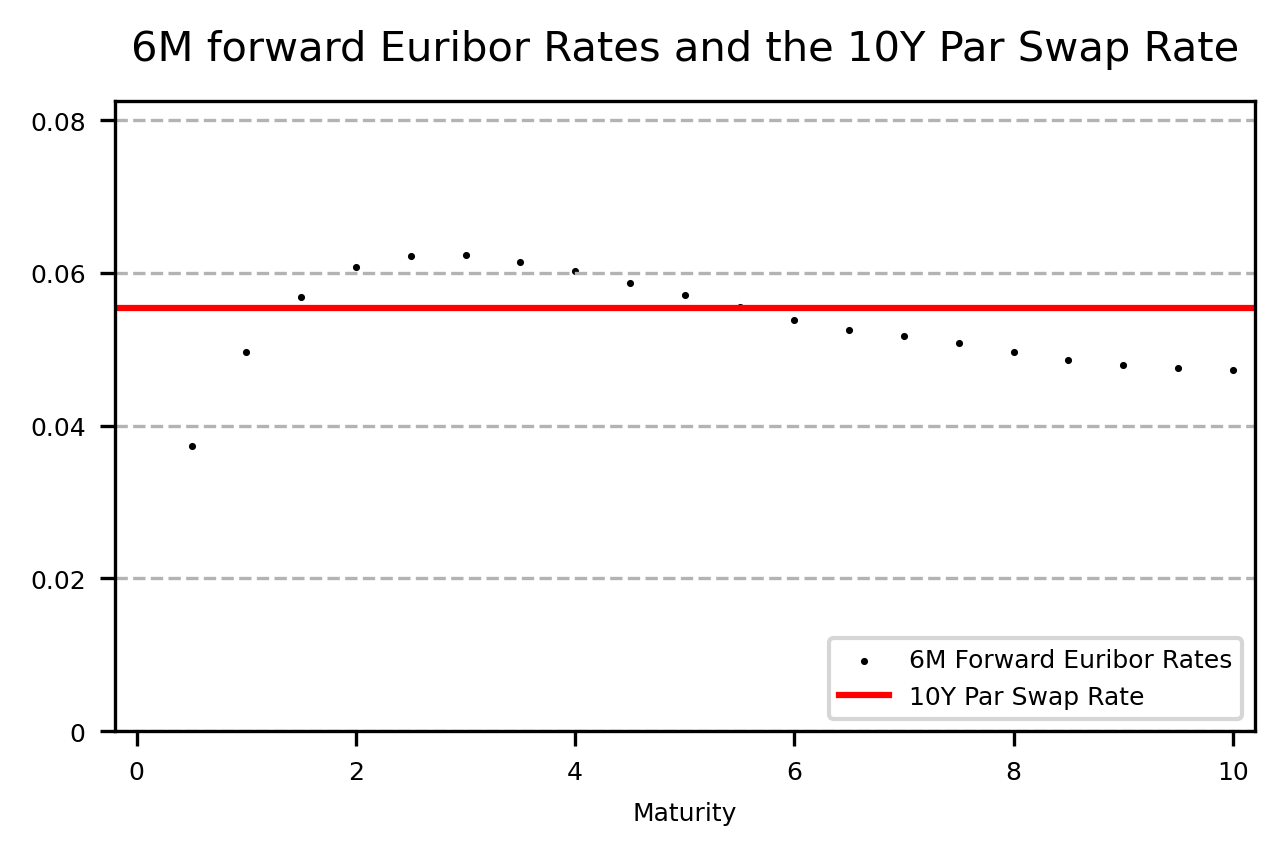

In [14]:

# Plot of 6M forward Euribor rates and the 10Y par swap rate
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"6M forward Euribor Rates and the 10Y Par Swap Rate", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = np.array([0,2,4,6,8,10])
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([0,0.0825])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_10Y_swap, L_6M, s = 2, color = 'black', marker = ".",label="6M Forward Euribor Rates")
p2 = ax.axhline(y=R_10Y_swap, linewidth = 1.5,color = 'red',label="10Y Par Swap Rate")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/1a_zcb_term_structure.pdf")
# plt.show()


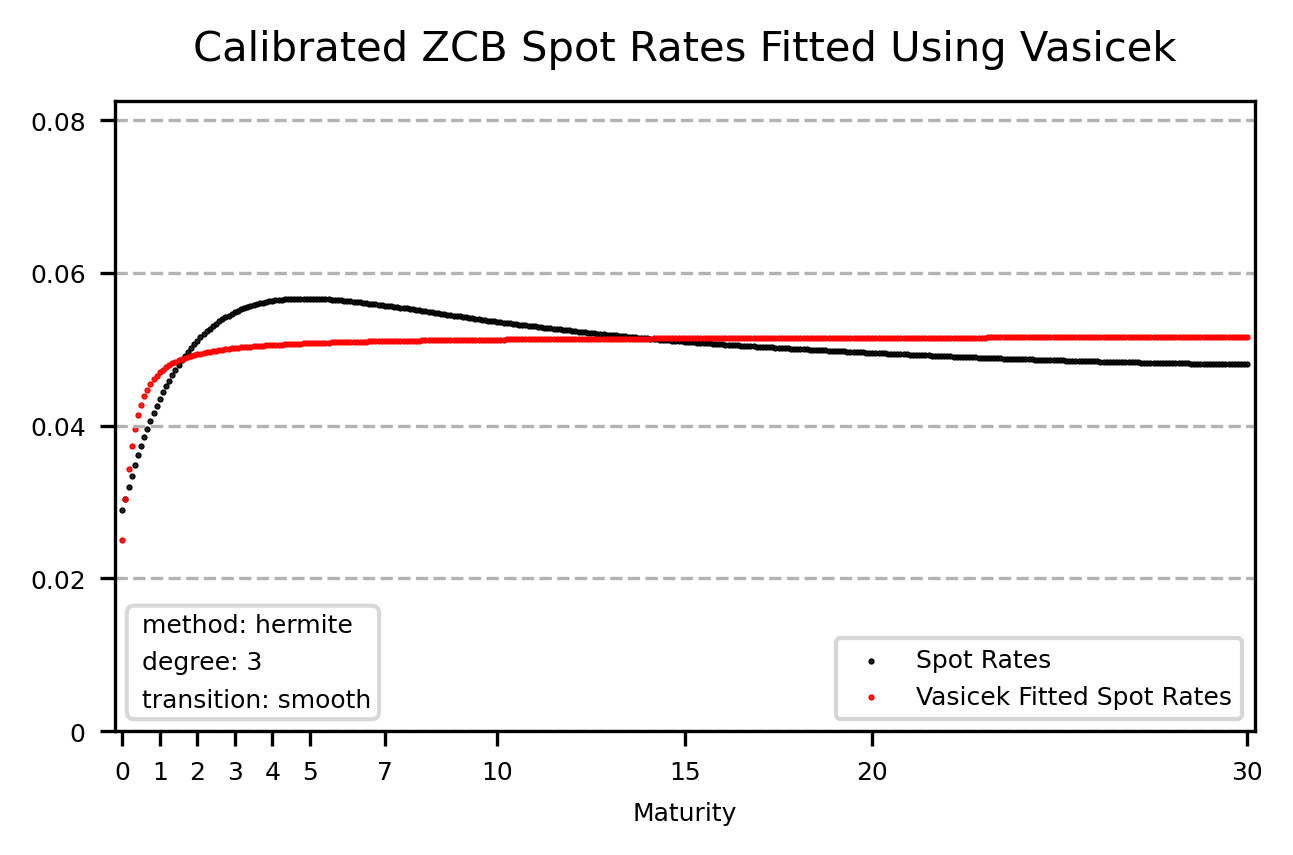

In [15]:

# Plot of Calibrated ZCB Spot Rates Fitted Using Vasicek
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated ZCB Spot Rates Fitted Using Vasicek", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([0,0.0825])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter[0:], R_inter[0:], s = 1, color = 'black', marker = ".",label="Spot Rates")
p2 = ax.scatter(T_inter, R_vasicek, s = 1, color = 'red', marker = ".",label="Vasicek Fitted Spot Rates")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
bbox = {"facecolor": (1,1,1,0.8),"edgecolor": (0.7,0.7,0.7,0.5),"boxstyle": "Round"}
if interpolation_options["method"] == "hermite":
    ax.text(0.32,0.0032,f" method: {interpolation_options['method']} \n degree: {interpolation_options['degree']} \n transition: {interpolation_options['transition']}", fontsize = 6,linespacing = 1.7, bbox = bbox)
else:
    ax.text(0.32,0.0032,f" method: {interpolation_options['method']} \n transition: {interpolation_options['transition']}", fontsize = 6,linespacing = 1.7, bbox = bbox)
fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/1a_zcb_term_structure.pdf")
# plt.show()


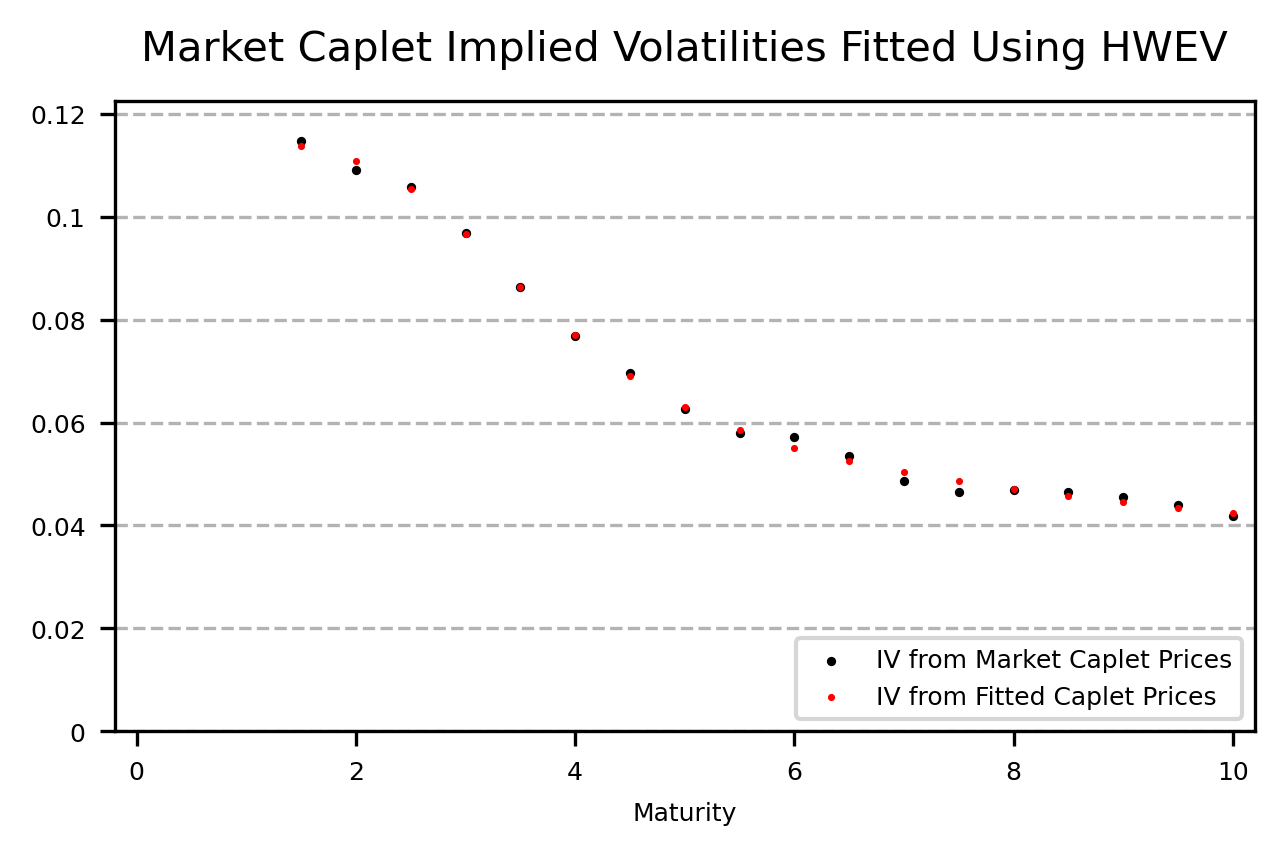

In [16]:

# Plot of fitted and observed caplet implied volatility
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Market Caplet Implied Volatilities Fitted Using HWEV", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = np.array([0,2,4,6,8,10])
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08,0.1,0.12])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08,0.1,0.12],fontsize = 6)
ax.set_ylim([0,0.1225])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_10Y_swap, sigma_market, s = 6, color = 'black', marker = ".",label="IV from Market Caplet Prices")
p2 = ax.scatter(T_10Y_swap, sigma_fit, s = 2, color = 'red', marker = ".",label="IV from Fitted Caplet Prices")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/1a_zcb_term_structure.pdf")
# plt.show()


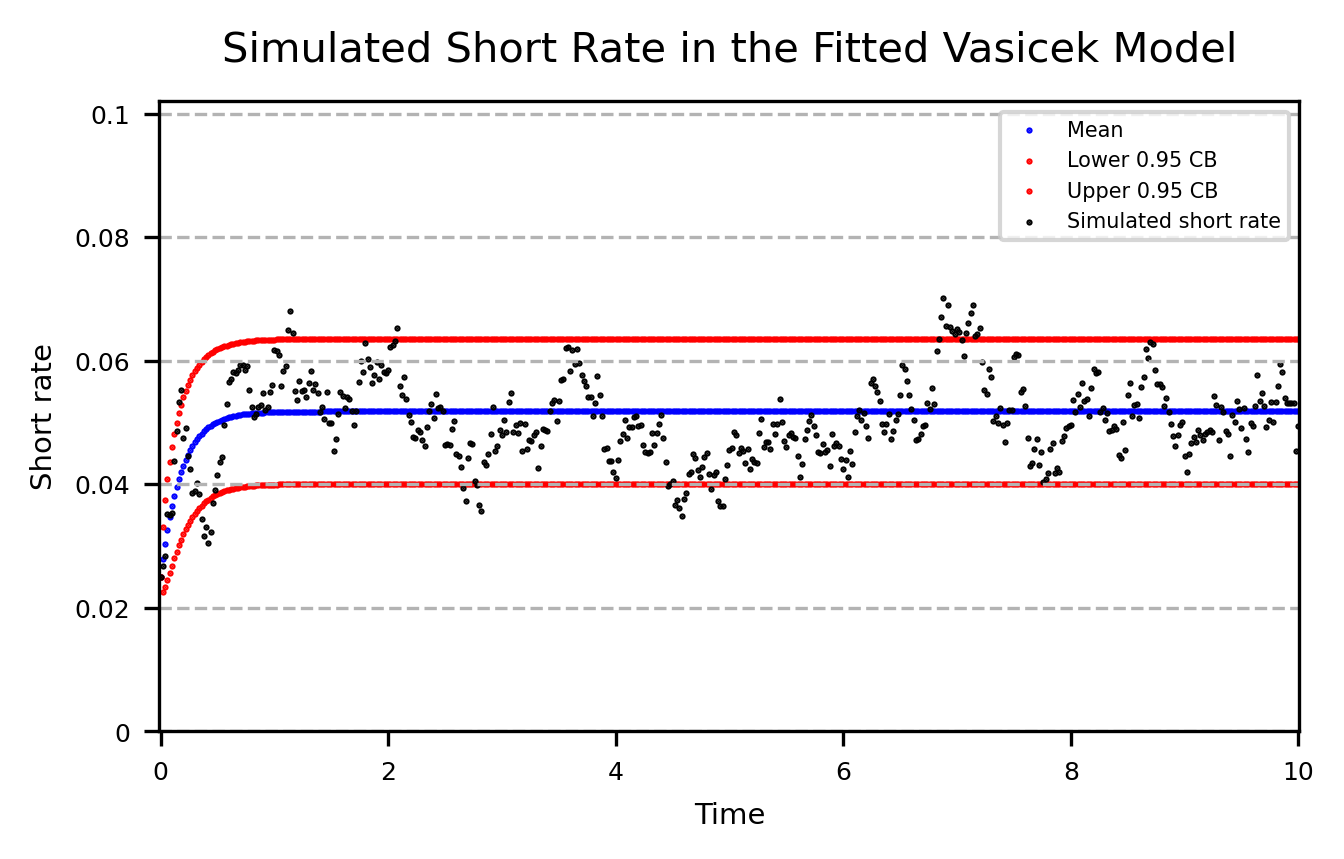

In [17]:

# PLot of simulated short rates in the Vasicek model
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Simulated Short Rate in the Fitted Vasicek Model",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.01,xticks[-1]+0.01])
plt.xlabel(f"Time",fontsize = 7)
yticks1 = [0,0.02,0.04,0.06,0.08,0.1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Short rate",fontsize = 7)
p1 = ax.scatter(t_simul, mean_vasicek, s = 1, color = 'blue', marker = ".",label=f"Mean")
p2 = ax.scatter(t_simul, lb_vasicek, s = 1, color = 'red', marker = ".",label=f"Lower {size_ci} CB")
p3 = ax.scatter(t_simul, ub_vasicek, s = 1, color = 'red', marker = ".",label=f"Upper {size_ci} CB")
p4 = ax.scatter(t_simul, r_simul_vasicek, s = 1, color = 'black', marker = ".",label="Simulated short rate")
plots = [p1,p2,p3,p4]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/1a_zcb_term_structure.pdf")
# plt.show()


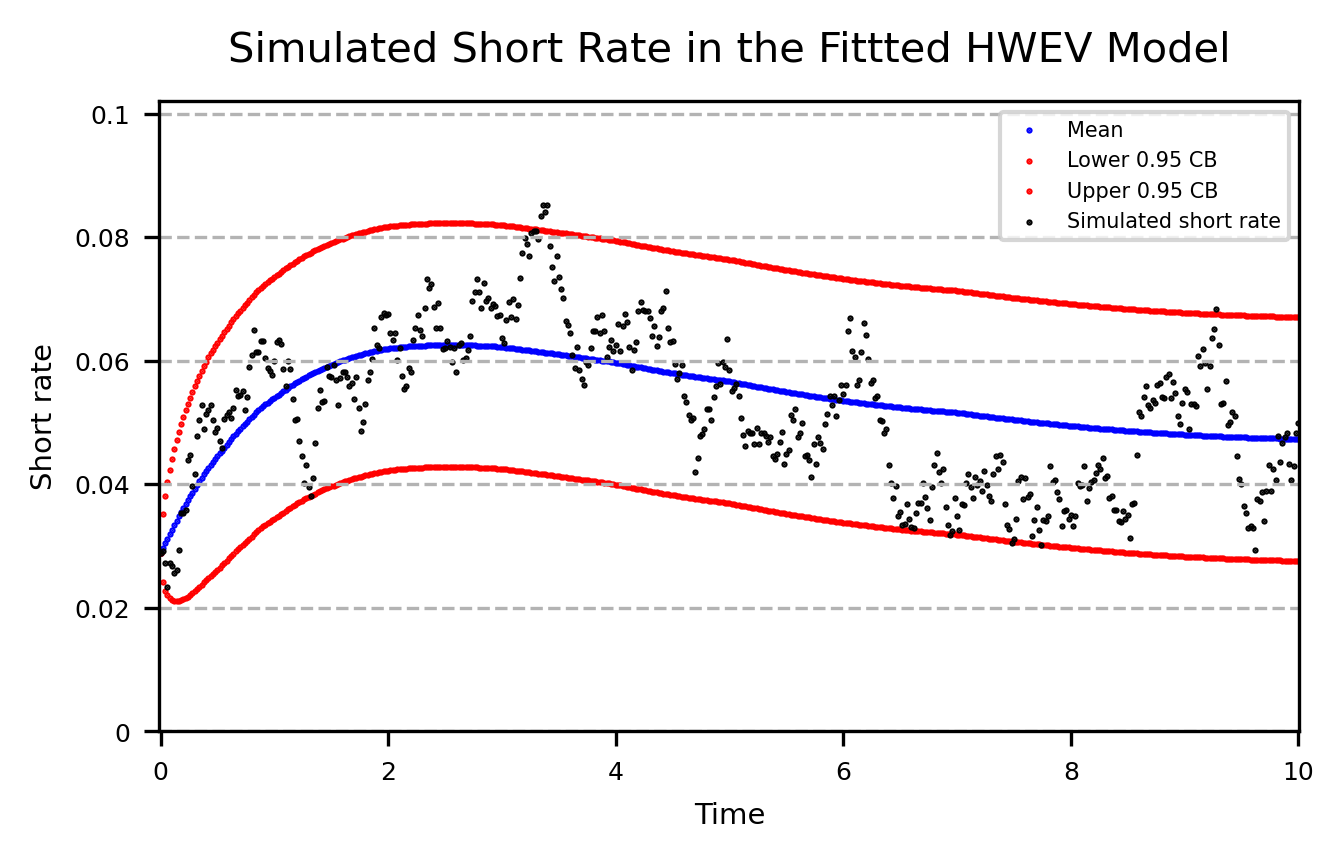

In [18]:

# PLot of simulated short rates in the Hull-White Extended Vasicek model
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Simulated Short Rate in the Fittted HWEV Model",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.01,xticks[-1]+0.01])
plt.xlabel(f"Time",fontsize = 7)
yticks1 = [0,0.02,0.04,0.06,0.08,0.1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Short rate",fontsize = 7)
p1 = ax.scatter(t_simul, mean_hwev, s = 1, color = 'blue', marker = ".",label=f"Mean")
p2 = ax.scatter(t_simul, lb_hwev, s = 1, color = 'red', marker = ".",label=f"Lower {size_ci} CB")
p3 = ax.scatter(t_simul, ub_hwev, s = 1, color = 'red', marker = ".",label=f"Upper {size_ci} CB")
p4 = ax.scatter(t_simul, r_simul_hwev, s = 1, color = 'black', marker = ".",label="Simulated short rate")
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/1a_zcb_term_structure.pdf")
# plt.show()


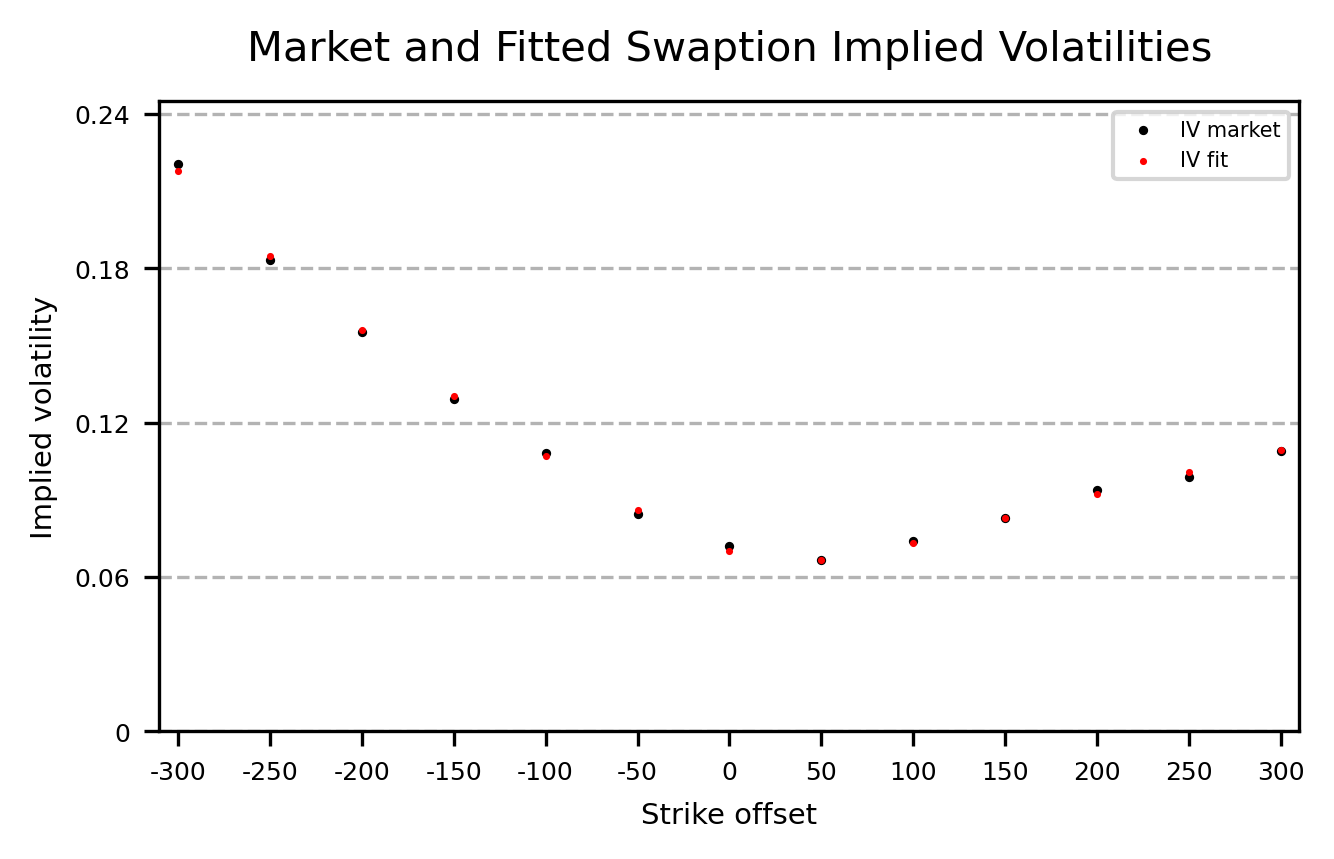

In [19]:

# Plot of swaption market implied volatilities
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Market and Fitted Swaption Implied Volatilities", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = K_swaption_offset
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-10,xticks[-1]+10])
plt.xlabel(f"Strike offset",fontsize = 7)
ax.set_yticks([0,0.06,0.12,0.18,0.24])
ax.set_yticklabels([0,0.06,0.12,0.18,0.24],fontsize = 6)
ax.set_ylim([0,0.245])
ax.set_ylabel(f"Implied volatility",fontsize = 7)
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(K_swaption_offset, iv_swaption_market, s = 6, color = 'black', marker = ".",label="IV market")
p2 = ax.scatter(K_swaption_offset, iv_fit, s = 2, color = 'red', marker = ".",label="IV fit")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/1a_zcb_term_structure.pdf")
# plt.show()


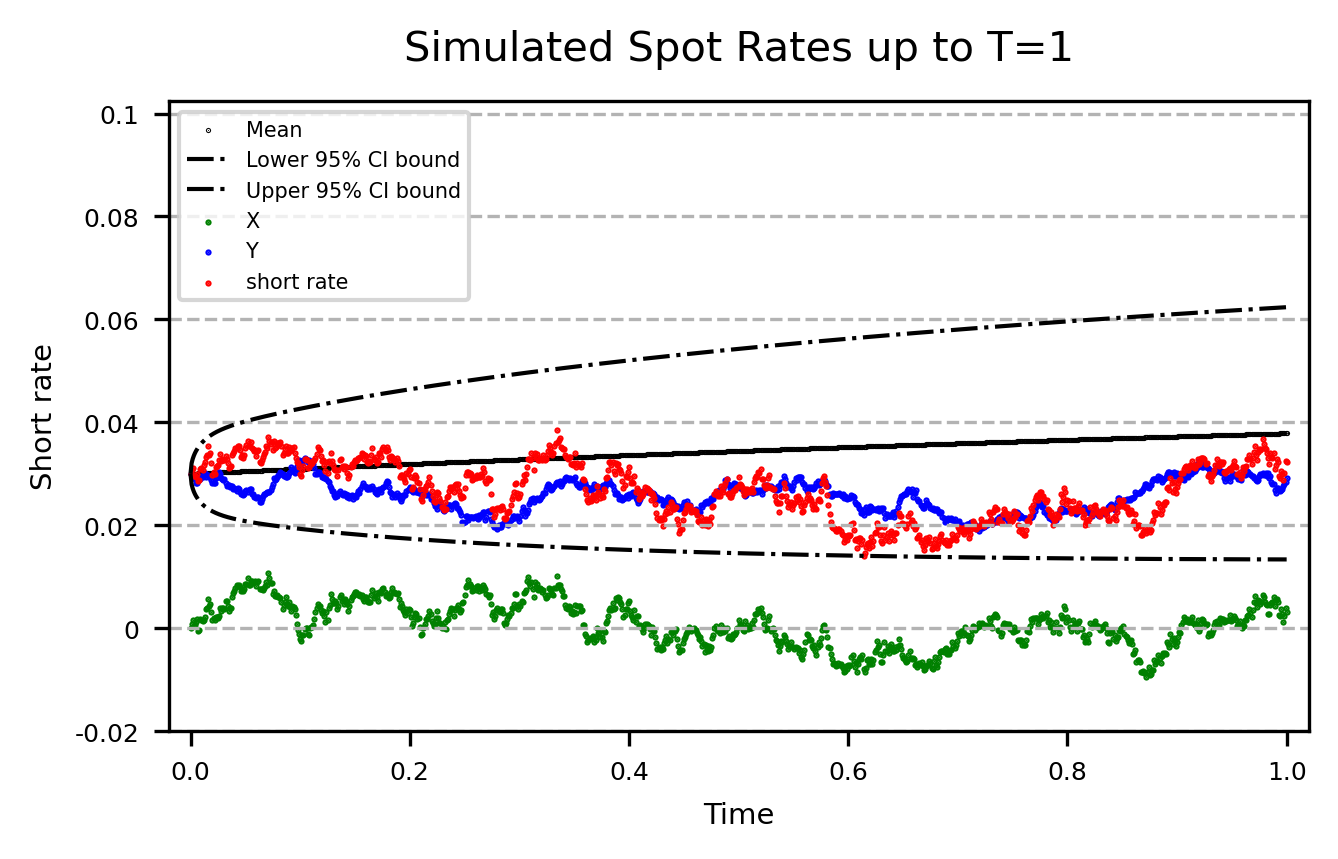

In [20]:

# PLot of Short term fluctuations
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Simulated Spot Rates up to T=1",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = np.array([0,0.2,0.4,0.6,0.8,1])
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.02*(xticks[-1]-xticks[0]),xticks[-1]+0.02*(xticks[-1]-xticks[0])])
plt.xlabel(f"Time",fontsize = 7)
yticks = [-0.02,0,0.02,0.04,0.06,0.08,0.1]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks,fontsize = 6)
ax.set_ylim([yticks[0],yticks[-1] + (yticks[-1]-yticks[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Short rate",fontsize = 7)
p1 = ax.scatter(t_simul_st, mean_st, s = 0.25, color = 'black', marker = ".",label=f"Mean")
p2 = ax.plot(t_simul_st, lb_st, color = 'black',linestyle = "dashdot", linewidth = 1,label=f"Lower 95% CI bound")
p3 = ax.plot(t_simul_st, ub_st, color = 'black',linestyle = "dashdot", linewidth = 1,label=f"Upper 95% CI bound")
p4 = ax.scatter(t_simul_st, X_st, s = 1, color = 'green', marker = ".",label=f"X")
p5 = ax.scatter(t_simul_st, Y_st, s = 1, color = 'blue', marker = ".",label=f"Y")
p6 = ax.scatter(t_simul_st, r_st, s = 1, color = 'red', marker = ".",label=f"short rate")
plots = [p1,p2[0],p3[0],p4,p5,p6]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper left",fontsize = 5)
fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/1a_zcb_term_structure.pdf")
# plt.show()


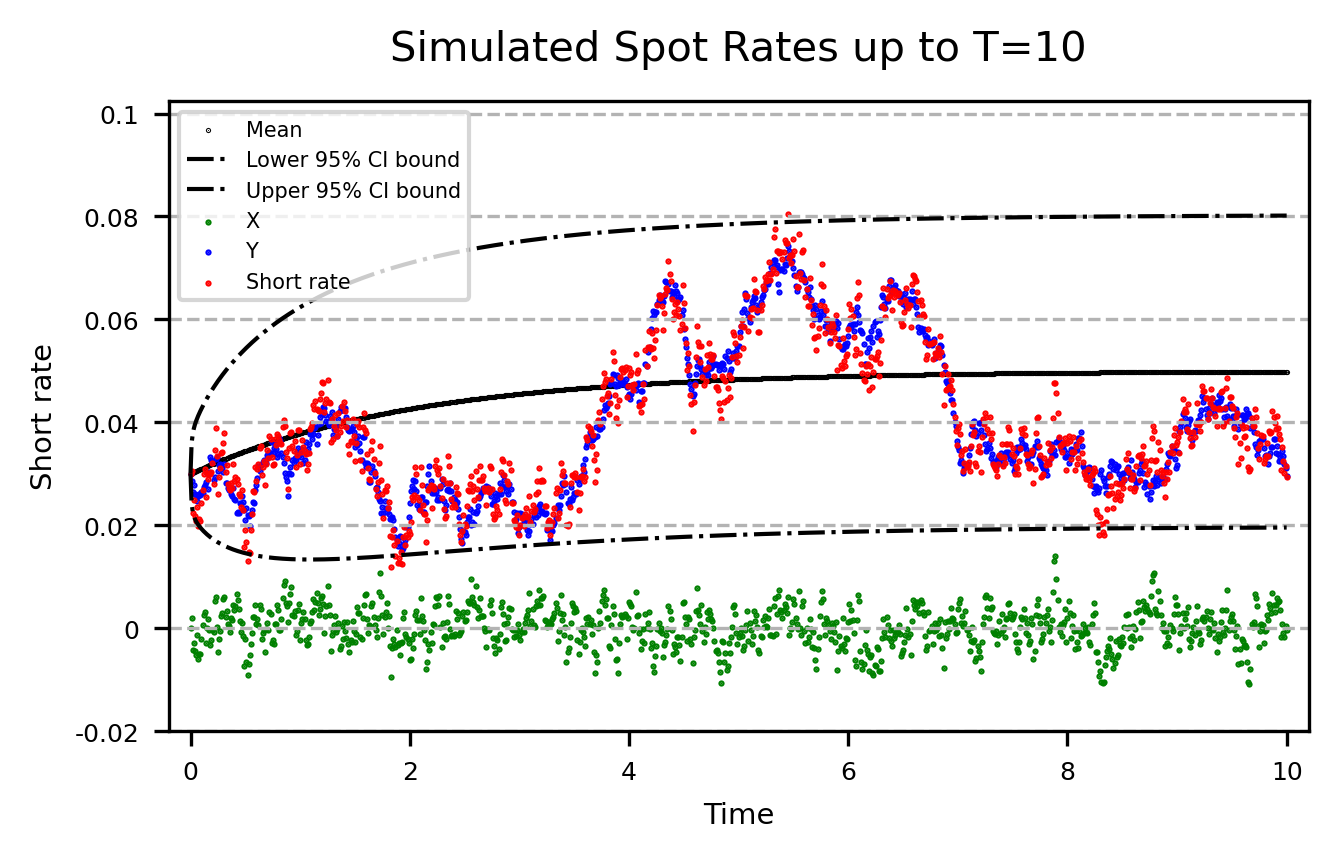

In [21]:

# PLot of long term fluctuations
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Simulated Spot Rates up to T=10",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = np.array([0,2,4,6,8,10])
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.02*(xticks[-1]-xticks[0]),xticks[-1]+0.02*(xticks[-1]-xticks[0])])
plt.xlabel(f"Time",fontsize = 7)
yticks = [-0.02,0,0.02,0.04,0.06,0.08,0.1]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks,fontsize = 6)
ax.set_ylim([yticks[0],yticks[-1] + (yticks[-1]-yticks[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Short rate",fontsize = 7)
p1 = ax.scatter(t_simul_lt, mean_lt, s = 0.25, color = 'black', marker = ".",label=f"Mean")
p2 = ax.plot(t_simul_lt, lb_lt, color = 'black',linestyle = "dashdot", linewidth = 1,label=f"Lower 95% CI bound")
p3 = ax.plot(t_simul_lt, ub_lt, color = 'black',linestyle = "dashdot", linewidth = 1,label=f"Upper 95% CI bound")
p4 = ax.scatter(t_simul_lt, X_lt, s = 1, color = 'green', marker = ".",label=f"X")
p5 = ax.scatter(t_simul_lt, Y_lt, s = 1, color = 'blue', marker = ".",label=f"Y")
p6 = ax.scatter(t_simul_lt, r_lt, s = 1, color = 'red', marker = ".",label=f"Short rate")
plots = [p1,p2[0],p3[0],p4,p5,p6]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper left",fontsize = 5)
fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/1a_zcb_term_structure.pdf")
#plt.show()
